In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import klib

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.metrics import classification_report,confusion_matrix

In [4]:
from sklearn.feature_selection import mutual_info_classif,SelectPercentile,chi2

In [44]:
import joblib

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Findings from EDA performed

*1)*    **So until now we have found that the MultiClass Dataset is highly Imbalanced for Stage 4.**

*2)*     **Out of the 19 features, 11 of them seems to be havinf missing values.Out of which 9 have missing percent more than 25%**

*3)*      **Cholesterol and Tryglicerides seems to be having high miss rates (more than 40%), so the best technique will be to dropping**

*4)*      **Out of the Numerical features {Cholesterol,Copper & SGOT} seems to have Saddle points over a range of values.Rest seems to be normal , but      skewed**

*5)*      **Some of the Numerical Features have Outliers, with maximum percent being 12.34%.If the missing values are handled carefully,Then ouliers can either be dropped or can be replaced using 'End of distribution' if it does not distort the Distribution of data.**

*6)*      **Since Outlier Count is low, we can safely use the Algorithms which are robust to outliers,Like SVM,Decision Tree,Random Forest,Gradient Boosting**

**Domain :** - Patients in **stages 1 and 2** show only a **one/two percent risk of death** a year after diagnosis, respectively. By the time a patient has reached **stage 3** , this **risk has increased to 20 percent**.
Only **39 percent of patients survive** the one-year mark post-diagnosis with **stage 4** liver cirrhosis



Based on domain knowledge, it is safe to assume that upto Stage 3 there are high survival rates(> 80%).

# Data Cleaning

In [13]:
df=pd.read_csv(r'train_dataset.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0
1,7326,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8,1.0
2,7254,297,D,NaN,27957,F,N,N,NaN,N,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3,3.0
3,3135,1872,C,D-penicillamine,21111,F,NaN,Y,Y,N,0.3,302.0,2.02,49.0,NaN,26.35,NaN,NaN,10.5,4.0
4,2483,939,CL,D-penicillamine,18061,F,NaN,NaN,NaN,N,0.5,344.0,3.11,91.0,NaN,104.56,NaN,306.0,11.4,2.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             6800 non-null   int64  
 1   N_Days         6800 non-null   int64  
 2   Status         6800 non-null   object 
 3   Drug           4775 non-null   object 
 4   Age            6800 non-null   int64  
 5   Sex            6800 non-null   object 
 6   Ascites        4554 non-null   object 
 7   Hepatomegaly   4373 non-null   object 
 8   Spiders        4210 non-null   object 
 9   Edema          6800 non-null   object 
 10  Bilirubin      6800 non-null   float64
 11  Cholesterol    3699 non-null   float64
 12  Albumin        6800 non-null   float64
 13  Copper         4644 non-null   float64
 14  Alk_Phos       4302 non-null   float64
 15  SGOT           4698 non-null   float64
 16  Tryglicerides  3988 non-null   float64
 17  Platelets      6462 non-null   float64
 18  Prothrom

In [15]:
y=df['Stage'].apply(lambda x : 1 if x!= 4 else 0)
y.head()

0    0
1    1
2    1
3    0
4    1
Name: Stage, dtype: int64

<AxesSubplot:xlabel='Stage', ylabel='count'>

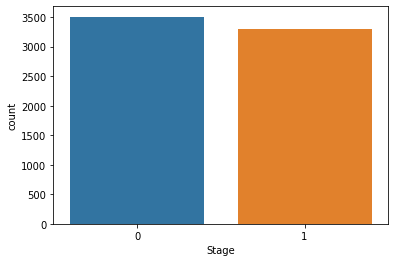

In [16]:
sns.countplot(y)

### Numerical Features

In [17]:
#This part of the code handle the Numerical Features of dataset
Num_Feats=[x for x in df.columns if df[x].dtype!='object' and x!='Stage']
Num_df=df[Num_Feats]
Num_df.head(3)

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,7135,1654,19581,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2
1,7326,41,22880,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8
2,7254,297,27957,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3


##### As we know from EDA performed, Cholesterol and Tryglicerides have high missing values, Therefore the need to be dropped.

In [18]:
#drops the coulumns with high miss rates
Num_df.drop(columns=['Cholesterol','Tryglicerides'],inplace=True)

In [19]:
#converting the "Age" feature from 'Days' To 'Years'
Num_df['Age']=Num_df['Age']//365

Capture the missing Numerical features, based on the distribution of the  features it seems best to impute them with median.

In [20]:
miss_feats=[x for x in Num_df.columns if Num_df[x].isna().sum() > 0]

In [21]:
def impute_nan(df,column,median):
        df[column]=df[column].fillna(median)

In [22]:
for column in miss_feats:
    median=Num_df[column].median()
    impute_nan(Num_df,column,median)

<AxesSubplot:xlabel='Prothrombin', ylabel='Density'>

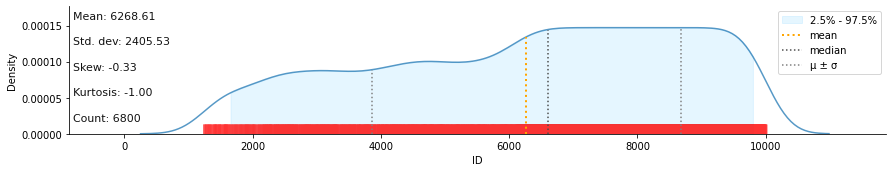

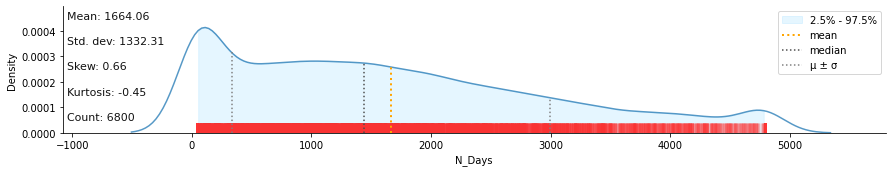

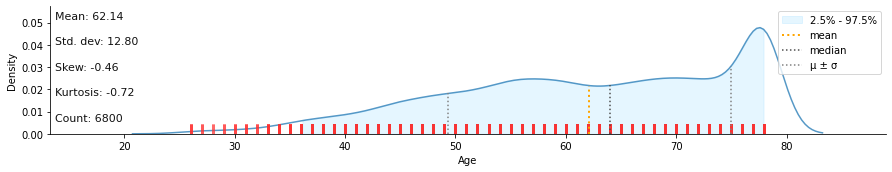

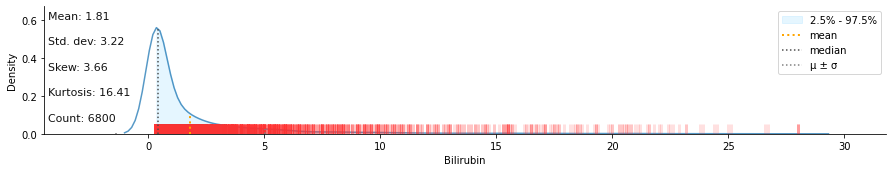

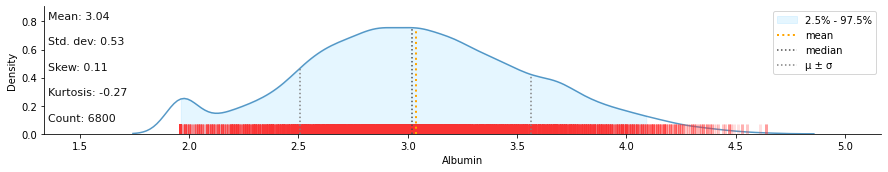

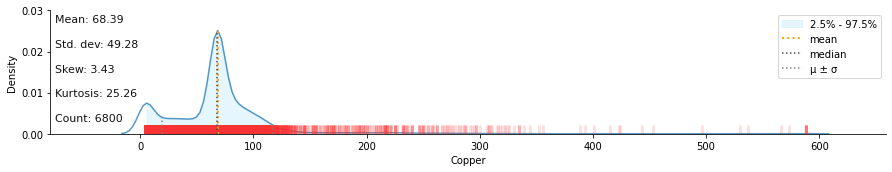

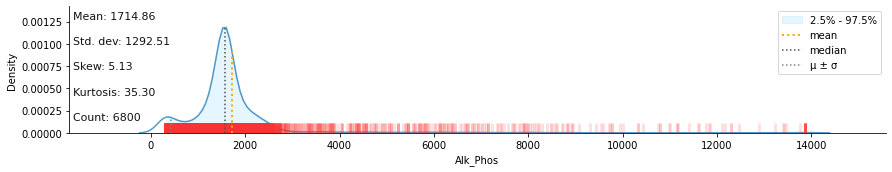

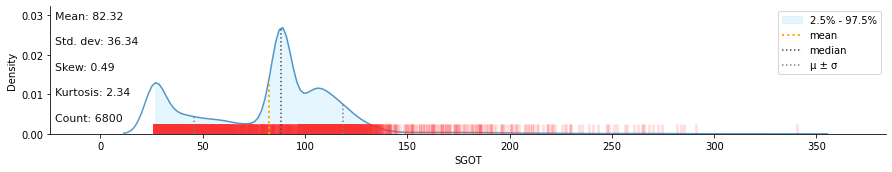

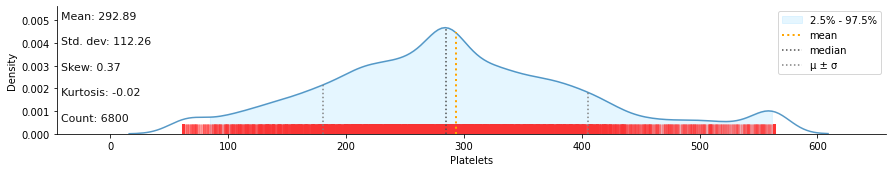

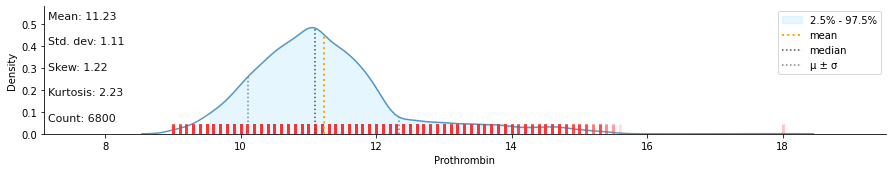

In [23]:
klib.dist_plot(Num_df)

<AxesSubplot:>

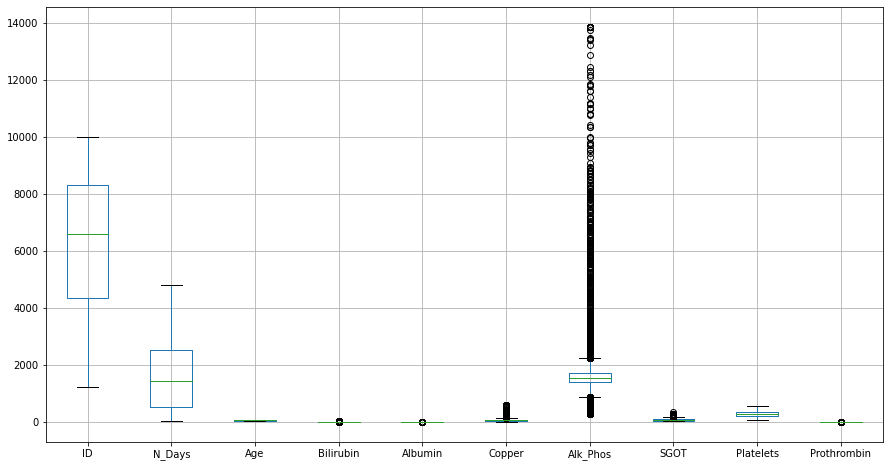

In [24]:
Num_df.boxplot(figsize=(15,8),fontsize=10)

#### Scaling the features

In [25]:
std=StandardScaler()
Num_df=pd.DataFrame(std.fit_transform(Num_df),columns=Num_df.columns)


In [52]:
data=np.array([10,2,34,5,64,12,3,43,23,45]).reshape(1,-1)
std.transform(data)

array([[ -2.60195291,  -1.24759252,  -2.19875554,   0.99256645,
        115.43450928,  -1.14424656,  -1.32454676,  -1.08220691,
         -2.40431425,  30.40725844]])

In [26]:
Num_df.head()

,ID,N_Days,Age,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Platelets,Prothrombin
0,0.360194,-0.007548,-0.714375,-0.468071,-0.144128,0.316787,-0.165628,0.470872,0.000951,-0.925620
1,0.439600,-1.218318,-0.011248,-0.468071,-0.144128,-0.007887,0.093268,-1.540452,0.134577,-0.385398
2,0.409667,-1.026156,1.082506,-0.468071,-0.750045,-1.306584,-0.117385,0.170192,-0.880980,-0.835583
3,-1.302766,0.156090,-0.401874,-0.468071,-1.924009,-0.393438,-0.117385,-1.540452,-0.070316,-0.655509
4,-1.573828,-0.544250,-1.026876,-0.405917,0.139896,0.458832,-0.117385,0.612061,0.116760,0.154824


Selecting Numerical Features

In [27]:
sel_cols = SelectPercentile(mutual_info_classif, percentile=60)
sel_cols.fit(Num_df,y)
Num_select=list(Num_df.columns[sel_cols.get_support()])
Num_select

['ID', 'N_Days', 'Age', 'Bilirubin', 'Albumin', 'Copper']

### Categorical Features

In [28]:
Cat_feats = [x for x in df.columns if df[x].dtype == 'object']
Cat_df = df[Cat_feats]
Cat_df.head(3)

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,CL,D-penicillamine,F,N,N,Y,N
1,C,D-penicillamine,F,NaN,N,NaN,N
2,D,NaN,F,N,N,NaN,N


<AxesSubplot:>

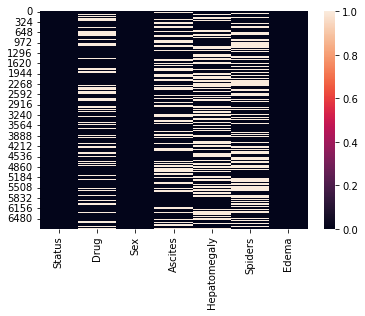

In [29]:
sns.heatmap(Cat_df.isnull())

In [30]:
pd.DataFrame(Cat_df.isna().sum(),columns=['Miss_count'])

,Miss_count
Status,0
Drug,2025
Sex,0
Ascites,2246
Hepatomegaly,2427
Spiders,2590
Edema,0


In [31]:
def Cat_encoding(df,feature):
    unique=[x for x in list(df[feature].unique()) if str(x) != 'nan']    
    d=dict((k,v) for (v,k) in enumerate(unique))
    df[feature]=df[feature].map(d)
    

In [32]:
for cols in Cat_df.columns:
    Cat_encoding(Cat_df,cols)

<AxesSubplot:>

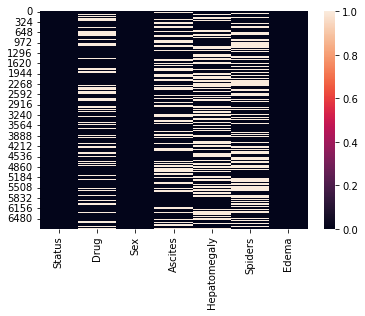

In [33]:
sns.heatmap(Cat_df.isnull())

**As there are high number of missing values in Categorical features, it is safe to use KNN Imputer**

In [34]:
def isqrt(n):
    x=n
    y=(x+1)//2
    while y<x:
        x=y
        y=(x+n//x)//2
    return x

In [35]:
k=isqrt(len(Cat_df))
cat_imputer=KNNImputer(n_neighbors=k,weights='distance')
X=cat_imputer.fit_transform(Cat_df)
Cat_df = pd.DataFrame(X,columns=Cat_feats)

In [36]:
def convertor(n):
    return 0 if n < 0.5 else 1 

In [37]:
for cols in ['Drug','Ascites','Spiders','Hepatomegaly']:
    Cat_df[cols] = Cat_df[cols].apply(convertor)

Selecting Categorical Features

In [38]:
sel_cat_cols = SelectPercentile(chi2, percentile=60)
sel_cat_cols.fit(Cat_df,y)
Cat_select=list(Cat_df.columns[sel_cat_cols.get_support()])
Cat_select

['Status', 'Sex', 'Ascites', 'Edema']

### Merging the Numerical and Categorical Features

In [39]:
X = pd.concat([Num_df[Num_select],Cat_df[Cat_select]],axis=1)
X.drop(columns=['ID'],inplace=True)
X.head()

,N_Days,Age,Bilirubin,Albumin,Copper,Status,Sex,Ascites,Edema
0,-0.007548,-0.714375,-0.468071,-0.144128,0.316787,0.0,0.0,0,0.0
1,-1.218318,-0.011248,-0.468071,-0.144128,-0.007887,1.0,0.0,0,0.0
2,-1.026156,1.082506,-0.468071,-0.750045,-1.306584,2.0,0.0,0,0.0
3,0.156090,-0.401874,-0.468071,-1.924009,-0.393438,1.0,0.0,0,0.0
4,-0.544250,-1.026876,-0.405917,0.139896,0.458832,0.0,0.0,0,0.0


In [64]:
X[Cat_select].nunique()

Status     3
Sex        2
Ascites    2
Edema      3
dtype: int64

### Train test Split

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True)

### Model Building

##### Since there are outliers in Numerical Features, Models selected must be such that are robust to outliers.
 1.)Decision Tree

 2.)Naive Bayes
 
 3.)Random Forest

 4.)AdaBoost
 
 5.)XGBoost

In [41]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [42]:
y_pred_tree = tree.predict(X_test)

In [48]:
print(confusion_matrix(y_test,y_pred_tree))

[[559 523]
 [500 458]]


In [45]:
rnd=RandomForestClassifier()
rnd.fit(X_train,y_train)
y_pred_rnd = rnd.predict(X_test)

In [54]:
print(confusion_matrix(y_test,y_pred_rnd))

0.5019607843137255

In [49]:
ada=AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)

In [50]:
print(classification_report(y_test,y_pred_ada))

              precision    recall  f1-score   support

           0       0.53      0.56      0.55      1082
           1       0.47      0.45      0.46       958

    accuracy                           0.51      2040
   macro avg       0.50      0.50      0.50      2040
weighted avg       0.51      0.51      0.51      2040



In [53]:
print(confusion_matrix(y_test,y_pred_ada))

[[609 473]
 [531 427]]


In [56]:
gbt= GradientBoostingClassifier()
gbt.fit(X_train,y_train)
y_pred_gbt = gbt.predict(X_test)

In [58]:
print(classification_report(y_test,y_pred_gbt))

              precision    recall  f1-score   support

           0       0.54      0.59      0.56      1082
           1       0.48      0.43      0.45       958

    accuracy                           0.51      2040
   macro avg       0.51      0.51      0.51      2040
weighted avg       0.51      0.51      0.51      2040



In [59]:
from sklearn.model_selection import GridSearchCV

In [82]:
classifier = GradientBoostingClassifier()
param_grid={
    "n_estimators" : [100,300,500,700],
    "max_depth"  :  [1,3,5,7],
}

model = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=10,
    cv=5
)

model.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START max_depth=1, n_estimators=100..............................
[CV 1/5; 1/16] END max_depth=1, n_estimators=100;, score=0.505 total time=   0.1s
[CV 2/5; 1/16] START max_depth=1, n_estimators=100..............................
[CV 2/5; 1/16] END max_depth=1, n_estimators=100;, score=0.535 total time=   0.1s
[CV 3/5; 1/16] START max_depth=1, n_estimators=100..............................
[CV 3/5; 1/16] END max_depth=1, n_estimators=100;, score=0.512 total time=   0.1s
[CV 4/5; 1/16] START max_depth=1, n_estimators=100..............................
[CV 4/5; 1/16] END max_depth=1, n_estimators=100;, score=0.513 total time=   0.1s
[CV 5/5; 1/16] START max_depth=1, n_estimators=100..............................
[CV 5/5; 1/16] END max_depth=1, n_estimators=100;, score=0.509 total time=   0.1s
[CV 1/5; 2/16] START max_depth=1, n_estimators=300..............................
[CV 1/5; 2/16] END max_depth=1, n_estimator

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 300, 500, 700]},
             scoring='accuracy', verbose=10)

In [83]:
print(model.best_score_)
print(model.best_estimator_)

0.5273109243697479
GradientBoostingClassifier()


In [ ]:
Rf_classifier = RandomForestClassifier()
param_grid={
    "n_estimators" : [100,300,500,700],
    "max_depth"  :  [1,3,5,7],
    "criterion" : ["gini","entropy"]
}

Rf_model = GridSearchCV(
    estimator=Rf_classifier,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=10,
    cv=5
)

Rf_model.fit(X_train,y_train)

In [ ]:
print(Rf_model.best_score_)

In [93]:
joblib.dump(Rf_model,'Rf_Baseline.pkl')

['Rf_Baseline.pkl']

In [1]:
new_df=df[Num_select+Cat_select]

NameError: name 'df' is not defined